In [1]:
import os
import re
import numpy as np
import librosa
import soundfile as sf
import random

from IPython.display import Audio, display
from matplotlib import pyplot as plt
from scipy.signal import fftconvolve

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
expand_dataset = False

## (Xaver) Vorverarbeitung

Path zu den Daten.

In [3]:
base_path = "Daten"

Die Namen der Daten speichern und sortieren weil Python anders sortiert.

In [4]:
files = [file for file in os.listdir(base_path)]
files = sorted(files)

## (Lasse) Datensatz Erweiterung


Audiodateien verändern um zusätzliche Dateien zu erzeugen

### Impulse Respone

In [5]:
sr = 44100

In [6]:
# load impulse response
try:
    # https://freesound.org/people/J.Zazvurek/sounds/680465/
    ir_bath, ir_bath_sr = librosa.load("IRs/bathroom-ir.wav", sr=None)
    if sr != ir_bath_sr:
        ir_bath = librosa.resample(y=ir_bath, orig_sr=ir_bath_sr, target_sr=sr)
        ir_bath_sr = sr
    
    # https://freesound.org/people/lemonzi/sounds/191308/
    ir_hall, ir_hall_sr = librosa.load("IRs/choirhall-ir.wav", sr=None)
    if sr != ir_hall_sr:
        ir_hall = librosa.resample(y=ir_hall, orig_sr=ir_hall_sr, target_sr=sr)
        ir_hall_sr = sr
except:
    print("Error: Could not load impulse response.")

Error: Could not load impulse response.


/tmp/ipykernel_13867/317331935.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  ir_bath, ir_bath_sr = librosa.load("IRs/bathroom-ir.wav", sr=None)
/home/xaver/.local/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


### Synthetische Sprecher

In [7]:
def speaker_1(y, sr):
    # pitch shift
    z = librosa.effects.pitch_shift(y, sr=sr, n_steps=2)

    # time stretch
    z = librosa.effects.time_stretch(z, rate=1.1)

    # time shift
    z = np.roll(z, 1200)

    # noise
    z = z + 0.0007 * np.random.randn(len(z))

    # impulse response
    try:
        original_len = len(z)
        z = fftconvolve(z, ir_bath*0.2, mode='full')
        z /= np.max(np.abs(z))
        z = z[:original_len]
    except:
        pass

    # volume
    z = z * 1.1

    return z

In [8]:
def speaker_2(y, sr):
    # pitch shift
    z = librosa.effects.pitch_shift(y, sr=sr, n_steps=-3)

    # time stretch
    z = librosa.effects.time_stretch(z, rate=0.8)

    # time shift
    z = np.roll(z, 2600)

    # noise
    z = z + 0.0004 * np.random.randn(len(z))

    # volume
    z = z * 0.8

    return z

In [9]:
def speaker_3(y, sr):
    # pitch shift
    z = librosa.effects.pitch_shift(y, sr=sr, n_steps=3)

    # time stretch
    z = librosa.effects.time_stretch(z, rate=1.5)

    # time shift
    z = np.roll(z, 3200)

    # noise
    z = z + 0.0007 * np.random.randn(len(z))

    # volume
    z = z * 1.3

    return z

In [10]:
def speaker_4(y, sr):
    # pitch shift
    z = librosa.effects.pitch_shift(y, sr=sr, n_steps=-1)

    # time stretch
    z = librosa.effects.time_stretch(z, rate=1.3)

    # time shift
    z = np.roll(z, 2600)

    # noise
    z = z + 0.0003 * np.random.randn(len(z))

    # volume
    z = z * 1.2

    return z

In [11]:
def speaker_5(y, sr):
    # pitch shift
    z = librosa.effects.pitch_shift(y, sr=sr, n_steps=-2)

    # time stretch
    z = librosa.effects.time_stretch(z, rate=0.9)

    # time shift
    z = np.roll(z, 1800)

    # noise
    z = z + 0.0002 * np.random.randn(len(z))

    # impulse response
    try:
        original_len = len(z)
        z = fftconvolve(z, ir_hall*0.15, mode='full')
        z /= np.max(np.abs(z))
        z = z[:original_len]
    except:
        pass

    # volume
    z = z * 0.8

    return z

In [12]:
def alter_audio(file_path):
    # load file
    y, sr = librosa.load(file_path, sr=None)
    
    y1 = speaker_1(y, sr)
    y2 = speaker_2(y, sr)
    y3 = speaker_3(y, sr)
    y4 = speaker_4(y, sr)
    y5 = speaker_5(y, sr)

    return [y1, y2, y3, y4, y5]

Veränderte Audiodateien abspeichern

In [13]:
def save_altered_audio(original_file, output_folder, altered_audios):
    # filenames and paths
    file_name = os.path.basename(original_file)
    name, ext = os.path.splitext(file_name)

    # save the original audio file (copy)
    target_path = os.path.join(output_folder, file_name)
    original_audio, sr = librosa.load(original_file, sr=None)
    sf.write(target_path, original_audio, sr)

    # save the altered audio files
    for i, audio in enumerate(altered_audios):
        altered_file_name = f"{name}{i+1}{ext}"
        altered_file_path = os.path.join(output_folder, altered_file_name)
        sf.write(altered_file_path, audio, sr)

Datensatz verarbeiten und erweiterten Datensatz speichern

In [14]:
def process_dataset(input_folder, output_folder):
    # create output folder if it doesn't exist already
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # iterate over each original audio file, then alter and save them
    for file_name in os.listdir(input_folder):
        file_path = os.path.join(input_folder, file_name)
        altered_audios = alter_audio(file_path)
        save_altered_audio(file_path, output_folder, altered_audios)

[Optional] Erweiterung des Datensatzes ausführen

In [15]:
if expand_dataset:
    # define input and output folders
    input_folder = base_path
    output_folder = input_folder + "2"

    # process the dataset and save the altered files in a new folder
    process_dataset(input_folder, output_folder)

    # update base_path to the new dataset
    base_path = output_folder

    # read in the newly created files
    files = [file for file in os.listdir(base_path)]
    files = sorted(files)

In [16]:
if expand_dataset:
    a_schwa_1s = [file for file in files if file.startswith("a_schwa_1")]
    syn_speaker_count = len(a_schwa_1s) - 1
    
    for i, file in enumerate(a_schwa_1s):
        cur_speaker = "Original" if i==0 else f"Synthetik {i}"
        print(f"Datei: {file:25} Sprecher: {cur_speaker}")
        audio_data, sr = librosa.load(base_path + "/" + file, sr=None)
        print(len(audio_data))
        display(Audio(data=audio_data, rate=sr, normalize=False))
else:
    syn_speaker_count = 0

## (Xaver) Labels

Anzahl der jeweiligen Datensätze. Diese kann dann je nach Anzahl angepasst werden.

In [17]:
if expand_dataset:
    amount_datasets = 3*(syn_speaker_count + 1)
else:
    amount_datasets = 12

Die Zahlen und Dateiendungen werden entfernt.

In [18]:
def cutNumbers(file):
    match = re.match(r'(.+?)_\d+\.wav$', file)
    if match:
        return match.group(1)
    return None

labels = [cutNumbers(file) for file in files]

counter = 0
labels_vocab = []
while counter < len(labels):
    labels_vocab.append(labels[counter])
    counter += amount_datasets

# unique Labels in labels_vocab gespeichert
for number, label in enumerate(labels_vocab):
    labels_vocab[number] = [number, labels_vocab[number]]

labels_vocab

[[0, 'a_schwa'],
 [1, 'close-mid_back_rounded'],
 [2, 'close-mid_back_unrounded'],
 [3, 'close-mid_central_rounded'],
 [4, 'close-mid_central_unrounded'],
 [5, 'close-mid_front_rounded'],
 [6, 'close-mid_front_unrounded'],
 [7, 'close_back_rounded'],
 [8, 'close_back_unrounded'],
 [9, 'close_central_rounded'],
 [10, 'close_central_unrounded'],
 [11, 'close_front_rounded'],
 [12, 'close_front_unrounded'],
 [13, 'open-mid_back_rounded'],
 [14, 'open-mid_back_unrounded'],
 [15, 'open-mid_central_rounded'],
 [16, 'open-mid_central_unrounded'],
 [17, 'open-mid_front_rounded'],
 [18, 'open-mid_front_unrounded'],
 [19, 'open_back_rounded'],
 [20, 'open_back_unrounded'],
 [21, 'open_front_rounded'],
 [22, 'open_front_unrounded'],
 [23, 'schwa']]

Das ist quasi eine Übersetzungstabelle um die Labels in Zahlen umzusetzen.

In [19]:
y = []
for combination in labels_vocab:
    for i in range(amount_datasets):
        y.append(combination[0])

y = np.array(y)
y = torch.from_numpy(y)
y = y.float()
y = torch.tensor(y, dtype=torch.long)

y

/tmp/ipykernel_13867/1437654631.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.long)


tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        18, 18, 18, 18, 18, 18, 18, 18, 

## (Xaver) Values
#### Die Signale werden in X gespeichert.
Es werden jeweils nur 0.25 Sekunden des Signals benutzt, da ich glaube dass wir nicht mehr brauchen. 


In [20]:
# (Xaver)
# paths_to_data = []
# counter = 0

# while counter < len(labels):

#     for i in range(amount_datasets):
#         paths_to_data.append(base_path + "/" + labels[counter] + "_" + str(i+1) + ".wav")
#     counter += amount_datasets

# paths_to_data

# (Lasse)
paths_to_data = [base_path + "/" + file for file in files]
paths_to_data

['Daten/a_schwa_1.wav',
 'Daten/a_schwa_10.wav',
 'Daten/a_schwa_11.wav',
 'Daten/a_schwa_12.wav',
 'Daten/a_schwa_2.wav',
 'Daten/a_schwa_3.wav',
 'Daten/a_schwa_4.wav',
 'Daten/a_schwa_5.wav',
 'Daten/a_schwa_6.wav',
 'Daten/a_schwa_7.wav',
 'Daten/a_schwa_8.wav',
 'Daten/a_schwa_9.wav',
 'Daten/close-mid_back_rounded_1.wav',
 'Daten/close-mid_back_rounded_10.wav',
 'Daten/close-mid_back_rounded_11.wav',
 'Daten/close-mid_back_rounded_12.wav',
 'Daten/close-mid_back_rounded_2.wav',
 'Daten/close-mid_back_rounded_3.wav',
 'Daten/close-mid_back_rounded_4.wav',
 'Daten/close-mid_back_rounded_5.wav',
 'Daten/close-mid_back_rounded_6.wav',
 'Daten/close-mid_back_rounded_7.wav',
 'Daten/close-mid_back_rounded_8.wav',
 'Daten/close-mid_back_rounded_9.wav',
 'Daten/close-mid_back_unrounded_1.wav',
 'Daten/close-mid_back_unrounded_10.wav',
 'Daten/close-mid_back_unrounded_11.wav',
 'Daten/close-mid_back_unrounded_12.wav',
 'Daten/close-mid_back_unrounded_2.wav',
 'Daten/close-mid_back_unround

In [21]:
def import_audio(paths_to_data):
    # Die Extraktion der Signale ist nicht abgesichert,
    # also wenn eine Datei mit weniger als 0.25 Sekunden brauchbarem Signal eingelesen wird gibt es einen OutOfBounds Error.

    X = []
    MFCCs = []
    cut_signals = []

    duration = 0.25

    # Signal ab echtem Signalstart beginnen lassen.
    for path in paths_to_data:
        signal, sr = librosa.load(path)

        # Normalisierung der Signale
        mean = np.mean(signal)
        std_dev = np.std(signal)
        signal = (signal - mean) / std_dev

        threshold = 0.05
        is_true_threshold = False
        signal_start = 0

        while is_true_threshold == False:
            is_true_threshold = False

            # Signal ab Schwellwert beginnen lassen.
            for i in range(len(signal[signal_start:])):
                if signal[i] < -threshold or signal[i] > threshold:
                    signal_start = signal_start + i
                    is_true_threshold = True
                    break

            # Prüfen ob es ein echtes Signal ist oder nur ein kurzes Signal, welches als Rauschen oder Knacken betrachtet werden kann.
                # Fenster von 0.05 Sekunden, in dem kein Wert unter dem Threshold liegen darf.
                # Dieser kann wenn nötig angepasst werden.

            for i in range(len(signal[signal_start:int(0.05 * sr)])):
                if ((0-threshold) < signal[i] and signal[i] < (0+threshold)):
                    is_true_threshold = False
                    signal_start += i
                    break

            if is_true_threshold == True:
                cut_signals.append(signal[signal_start:signal_start + int(duration*sr)])
                break

        # librosa resamples to 22050 Hz.
            # y -> raw audio data
            # sr -> sample rate 22050 Hz
        # Hamming-Window wird automatisch bei Feature-Extraction gemacht.

    for signal in cut_signals:
        melspectrogram = librosa.feature.melspectrogram(y=signal, sr=sr)
        log_melspectrogram = librosa.power_to_db(melspectrogram)
        mfcc = librosa.feature.mfcc(S=log_melspectrogram, sr=sr, n_mfcc=13)
        mfcc = torch.tensor(mfcc)

        MFCCs.append(mfcc)

    X = torch.stack(MFCCs)
    return X

In [22]:
X = import_audio(paths_to_data)

# (Fritz) Teile die vorhandenen Daten in ein Test und Trainingsset

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25#, random_state=0
)

#  (Xaver) Netzwerk

In [24]:
class PhonemeClassifier(nn.Module):

    def __init__(self):
        super(PhonemeClassifier, self).__init__()

        self.hidden_layer1 = nn.Linear(13*11, 256)
        self.hidden_layer2 = nn.Linear(256, 128)
        self.hidden_layer3 = nn.Linear(128, 64)
        self.hidden_layer4 = nn.Linear(128, 64)
        self.hidden_layer5 = nn.Linear(64, 24)
        self.relu1 = nn.ReLU()

    def forward(self, x_in):
        x = self.hidden_layer1(x_in)
        x = self.relu1(x)
        x = self.hidden_layer2(x)
        x = self.relu1(x)
        x = self.hidden_layer3(x)
        x = self.relu1(x)
        x = self.hidden_layer5(x)
        return x

## Training & Überwachung

### (Xaver/Fritz) Accuracy

In [25]:
def Inference(signal, model):
    with torch.no_grad():
        model.eval()
        signal = signal.to(next(model.parameters()).device)
        predicted_label = torch.argmax(model(signal), dim=1)
    return predicted_label

def calc_acc(X_test, y_test, model):
    test_labels = []
    test_predictions = []
    # für jedes test_file <- (X_test[i])   test_label <- (y_test[i])
    for test_file, test_label in zip(X_test, y_test):
        test_file = test_file.flatten().clone().detach().unsqueeze(0).float()
        model_prediction = Inference(test_file, model)
        test_labels.append(test_label)
        test_predictions.append(model_prediction.item())

    return accuracy_score(test_labels, test_predictions)

def shuffle_data(X_train, y_train):
    combined = list(zip(X_train, y_train))
    random.shuffle(combined)

    x_shuffled, y_shuffled = zip(*combined)

    x_shuffled = list(x_shuffled)
    y_shuffled = list(y_shuffled)

    return x_shuffled, y_shuffled

### (Xaver/Lasse) Training

In [26]:
def train_model(X_train, y_train, model, optimizer, n_epochs, loss_function):
    loss_scores = []
    accuracy_scores = []

    for epoch in range(n_epochs):
        model.train()
        loss_total = 0.0
        
        for i in range(len(X_train)):
            optimizer.zero_grad()
            y_pred = model(X_train[i].flatten())
            loss_now = loss_function(y_pred, y_train[i])
            loss_now.backward()
            optimizer.step()
            loss_total += loss_now.item()
        
        loss = (loss_total / len(X_train))/3
        loss_scores.append(loss)
        accuracy = calc_acc(X_test, y_test, model)
        accuracy_scores.append(accuracy)
    
        print(f"Epoch: {epoch + 1:3} - Accuracy: {accuracy:.4f} - Loss: {loss:.4f}")
        X_train, y_train = shuffle_data(X_train, y_train)
    
    return loss_scores, accuracy_scores

### (Lasse) Learning Rate Tests & Ergebnisse

In [27]:
def test_lrs(lrs, n_epochs):
    models_lr = {}
    loss_scores_lr = []
    accuracy_scores_lr = []
    for lr in lrs:
        print(f"\nLearning rate: {lr}")
        loss_function = nn.CrossEntropyLoss()
        
        # Hier ist das Model
        cur_model = PhonemeClassifier()
        cur_optimizer = optim.Adam(params=cur_model.parameters(), lr=lr)

        loss_scores, accuracy_scores = train_model(X_train, y_train, cur_model, cur_optimizer, n_epochs, loss_function)

        models_lr[lr] = cur_model
        loss_scores_lr.append(loss_scores)
        accuracy_scores_lr.append(accuracy_scores)
    
    return models_lr, loss_scores_lr, accuracy_scores_lr

In [28]:
lrs1 = [0.001, 0.0005, 0.0001]
n_epochs1 = 60

models_lr, losses1, accuracies1 = test_lrs(lrs1, n_epochs1)


Learning rate: 0.001
Epoch:   1 - Accuracy: 0.0278 - Loss: 1.2318
Epoch:   2 - Accuracy: 0.0972 - Loss: 0.9497
Epoch:   3 - Accuracy: 0.0833 - Loss: 0.8455
Epoch:   4 - Accuracy: 0.1250 - Loss: 0.7855
Epoch:   5 - Accuracy: 0.1250 - Loss: 0.7926
Epoch:   6 - Accuracy: 0.0417 - Loss: 0.7510
Epoch:   7 - Accuracy: 0.0972 - Loss: 0.6926
Epoch:   8 - Accuracy: 0.0972 - Loss: 0.6529
Epoch:   9 - Accuracy: 0.0694 - Loss: 0.5978
Epoch:  10 - Accuracy: 0.1389 - Loss: 0.5839
Epoch:  11 - Accuracy: 0.0972 - Loss: 0.6016
Epoch:  12 - Accuracy: 0.0972 - Loss: 0.5447
Epoch:  13 - Accuracy: 0.1111 - Loss: 0.5039
Epoch:  14 - Accuracy: 0.1667 - Loss: 0.4556
Epoch:  15 - Accuracy: 0.1389 - Loss: 0.4289
Epoch:  16 - Accuracy: 0.1250 - Loss: 0.4995
Epoch:  17 - Accuracy: 0.1389 - Loss: 0.4437
Epoch:  18 - Accuracy: 0.1389 - Loss: 0.4286
Epoch:  19 - Accuracy: 0.1389 - Loss: 0.3988
Epoch:  20 - Accuracy: 0.1250 - Loss: 0.3957
Epoch:  21 - Accuracy: 0.1528 - Loss: 0.3557
Epoch:  22 - Accuracy: 0.0972 - L

# (Lasse) Graphs

## Learning-Rate Optimierung
[Understanding Learning Rate](https://towardsdatascience.com/https-medium-com-dashingaditya-rakhecha-understanding-learning-rate-dd5da26bb6de)

Optimierung der Learning Rate nach dem folgendem Graph:

![Alt text](https://miro.medium.com/v2/resize:fit:640/format:webp/0*C5kIkoBwht0fXRgs.jpeg)

### Graph functions

In [29]:
import matplotlib.pyplot as plt
import numpy as np

In [30]:
# Training Loss
def graph_loss_by_lr(lrs, loss_scores_lr, n_epochs, nr):
    plt.plot(np.rot90(loss_scores_lr, 3), marker = 'o')
    plt.axis([0, n_epochs, 0, 1])

    plt.title(f"Training Loss #{nr} per Learning Rate")
    plt.xlabel("Epoch Number")
    plt.ylabel("Loss (%)")

    plt.legend(lrs[::-1])
    plt.grid()

    plt.show()

In [31]:
# Test Accuracy 
def graph_accuracy_by_lr(lrs, accuracy_scores_lr, n_epochs, nr):
    plt.plot(np.rot90(accuracy_scores_lr, 3), marker = 'o')
    plt.axis([0, n_epochs, 0, 1])

    plt.title(f"Test Accuracy #{nr} per Learning Rate")
    plt.xlabel("Epoch Number")
    plt.ylabel("Accuracy (%)")

    plt.legend(lrs[::-1])
    plt.grid()

    plt.show()

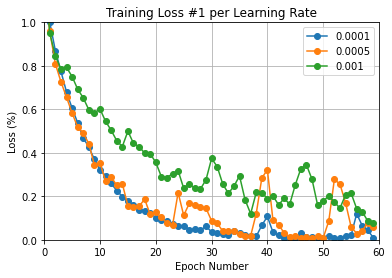

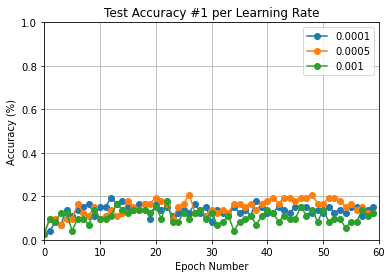

In [32]:
# Plots 1
graph_loss_by_lr(lrs1, losses1, n_epochs1, 1)
graph_accuracy_by_lr(lrs1, accuracies1, n_epochs1, 1)

In [33]:
lrs2 = [0.0002, 0.0001, 0.00009, 0.00008]
n_epochs2 = 60

models_lr2, losses2, accuracies2 = test_lrs(lrs2, n_epochs2)


Learning rate: 0.0002
Epoch:   1 - Accuracy: 0.1250 - Loss: 1.2104
Epoch:   2 - Accuracy: 0.1111 - Loss: 0.9050
Epoch:   3 - Accuracy: 0.1667 - Loss: 0.7505
Epoch:   4 - Accuracy: 0.1250 - Loss: 0.6436
Epoch:   5 - Accuracy: 0.1944 - Loss: 0.5489
Epoch:   6 - Accuracy: 0.1806 - Loss: 0.4772
Epoch:   7 - Accuracy: 0.1944 - Loss: 0.4008
Epoch:   8 - Accuracy: 0.2361 - Loss: 0.3608
Epoch:   9 - Accuracy: 0.1806 - Loss: 0.3290
Epoch:  10 - Accuracy: 0.1806 - Loss: 0.2604
Epoch:  11 - Accuracy: 0.1667 - Loss: 0.2212
Epoch:  12 - Accuracy: 0.1528 - Loss: 0.2019
Epoch:  13 - Accuracy: 0.1944 - Loss: 0.1923
Epoch:  14 - Accuracy: 0.1806 - Loss: 0.1487
Epoch:  15 - Accuracy: 0.2222 - Loss: 0.1476
Epoch:  16 - Accuracy: 0.1250 - Loss: 0.1164
Epoch:  17 - Accuracy: 0.1667 - Loss: 0.0979
Epoch:  18 - Accuracy: 0.1806 - Loss: 0.0830
Epoch:  19 - Accuracy: 0.1806 - Loss: 0.0896
Epoch:  20 - Accuracy: 0.1389 - Loss: 0.0703
Epoch:  21 - Accuracy: 0.1944 - Loss: 0.1045
Epoch:  22 - Accuracy: 0.1111 - 

In [34]:
models_lr = models_lr | models_lr2

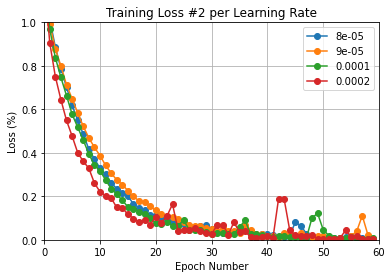

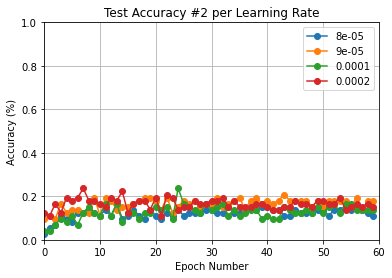

In [35]:
# Plots 2
graph_loss_by_lr(lrs2, losses2, n_epochs2, 2)
graph_accuracy_by_lr(lrs2, accuracies2, n_epochs2, 2)

In [36]:
chosen_model = models_lr[0.0002]

In [37]:
for i in range(len(y_test)):
    predicted_label = torch.argmax(chosen_model(X_test[i].flatten()))
    #print(y_test[i].item(), predicted_label.item())
    print(f"Testeingabe     : {labels_vocab[y_test[i].item()][1]}\nErkanntes Phonem: {labels_vocab[predicted_label.item()][1]}\n")

Testeingabe     : close_central_rounded
Erkanntes Phonem: close_back_rounded

Testeingabe     : open_back_rounded
Erkanntes Phonem: close-mid_back_rounded

Testeingabe     : close_back_unrounded
Erkanntes Phonem: close-mid_back_unrounded

Testeingabe     : close_back_unrounded
Erkanntes Phonem: close-mid_back_rounded

Testeingabe     : open-mid_back_unrounded
Erkanntes Phonem: open-mid_central_unrounded

Testeingabe     : close_back_rounded
Erkanntes Phonem: close-mid_central_rounded

Testeingabe     : open-mid_front_unrounded
Erkanntes Phonem: a_schwa

Testeingabe     : open-mid_central_rounded
Erkanntes Phonem: open_back_unrounded

Testeingabe     : open_back_rounded
Erkanntes Phonem: open-mid_back_rounded

Testeingabe     : open_back_unrounded
Erkanntes Phonem: open-mid_back_rounded

Testeingabe     : open_back_rounded
Erkanntes Phonem: open-mid_central_rounded

Testeingabe     : open_back_rounded
Erkanntes Phonem: open-mid_back_rounded

Testeingabe     : close_central_rounded
Erkan

# (Fritz) Validierung über das generierte Test-set

In [38]:
def Inference(signal, ml_model):
    predicted_label = torch.argmax(ml_model(signal))
    return predicted_label

test_labels = []
test_predictions = []
# für jedes test_file <- (X_test[i])   test_label <- (y_test[i])
for test_file, test_label in zip(X_test, y_test):
    model_prediction = Inference(test_file.flatten(), chosen_model)
    test_labels.append(test_label)
    test_predictions.append(model_prediction)

#Die accuracy zeigt an wie genau das modell in seinen vorhersagen ist: 1.0 = perfekt, 0 = gar keine treffer
print(f"Accuracy: {accuracy_score(test_labels, test_predictions)}")

#Die confusion matrix zeigt welche klassen mit welchen verwechselt wurden
#confusion_matrix(test_labels, test_predictions)

Accuracy: 0.1527777777777778
